In [2]:
library(rstan)
library(brms)
library(here)
library(bayesplot)
library(ggfortify)
library(gridExtra)


# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


要求されたパッケージ StanHeaders をロード中です


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


要求されたパッケージ Rcpp をロード中です

Loading 'brms' package (version 2.21.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


次のパッケージを付け加えます: ‘brms’


以下のオブジェクトは ‘package:rstan’ からマスクされています:

    loo


以下のオブジェクトは ‘package:stats’ からマスクされています:

    ar


here() starts at /media/e595/Game/プロジェクト置き場/RとStanで始めるベイズ統計モデリング

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot:

In [3]:
set.seed(1)
wn <- rnorm(n = 100, mean = 0, sd = 1)


In [4]:
rw <- cumsum(wn)


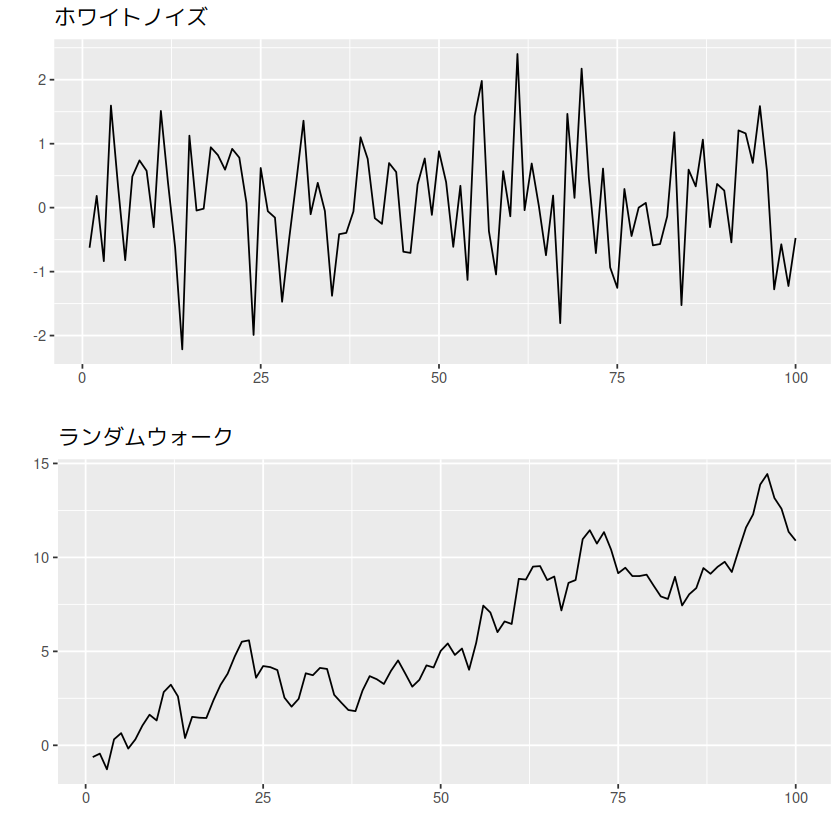

In [5]:
rw <- cumsum(wn)p_wn_1 <- autoplot(ts(wn), main = "ホワイトノイズ")
p_rw_1 <- autoplot(ts(rw), main = "ランダムウォーク")

grid.arrange(p_wn_1, p_rw_1)


List of 1
 $ legend.position: chr "none"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

List of 1
 $ legend.position: chr "none"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

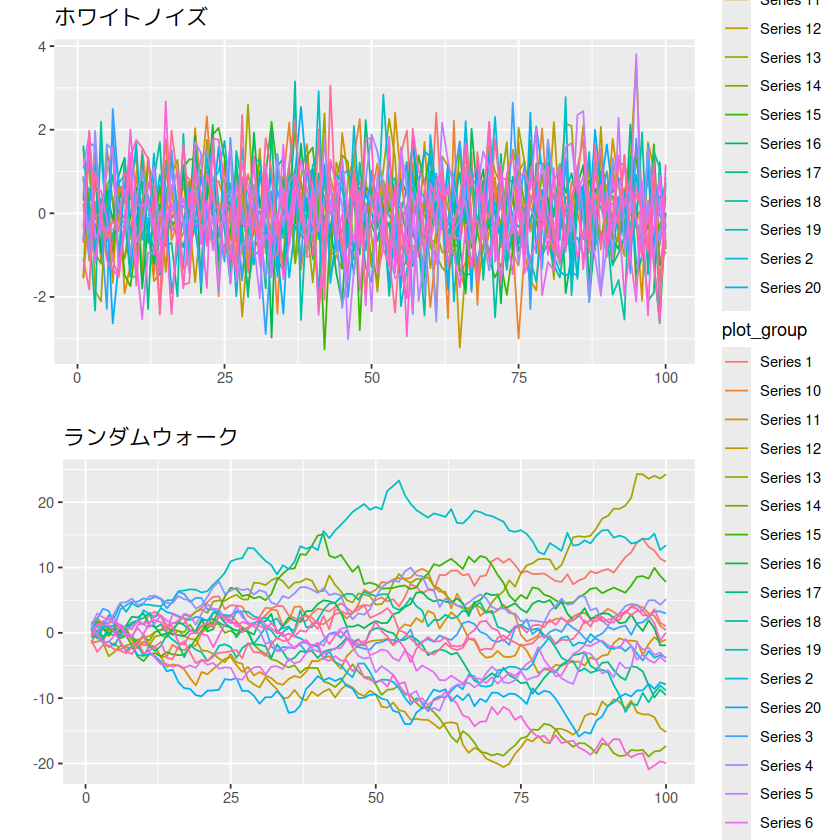

In [17]:
wn_mat <- matrix(nrow = 100, ncol = 20)
rw_mat <- matrix(nrow = 100, ncol = 20)
set.seed(1)
for (i in 1:20) {
  wn <- rnorm(n = 100, mean = 0, sd = 1)
  wn_mat[, i] <- wn
  rw_mat[, i] <- cumsum(wn)
}
p_wn_2 <- autoplot(ts(wn_mat), facets = F, main = "ホワイトノイズ")
theme(legend.position = "none") # 盆例を消す
p_rn_2 <- autoplot(ts(rw_mat), facets = F, main = "ランダムウォーク")
theme(legend.position = "none")

grid.arrange(p_wn_2, p_rn_2)


In [7]:
# データの読み込み
sales_df <- read.csv(here("data", "5-2-1-sales-ts-1.csv"))
sales_df$date <- as.POSIXct(sales_df$date)
head(sales_df, n = 3)


,date,sales
,<dttm>,<dbl>
1,2010-01-01,23.9
2,2010-01-02,19.0
3,2010-01-03,20.3


In [18]:
POSIXct_time <- as.POSIXct("1970-01-01 00:00:05", tz = "UTC")
as.numeric(POSIXct_time)


[1] 5

data_list <- list(
  y = sales_df$sales,
  T = nrow(sales_df)
)
local_leven_stan <- stan(
  file = here("5部", "5-2.1-local-level.stan"),
  data = data_list,
  seed = 1
)


In [19]:
mcmc_sample <- rstan::extract(local_leven_stan)


In [36]:
state_name <- "mu"
result_df <- data.frame(t(apply(
  X = mcmc_sample[[state_name]],
  MARGIN = 2,
  FUN = quantile,
  probs = c(0.025, 0.5, 0.975)
)))
colnames(result_df) <- c("lwr", "fit", "upr")
result_df$time <- sales_df$date
result_df$obs <- sales_df$sales


In [34]:
head(result_df, n = 3)


,lwt,fit,upr,time,obs
,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>
1,18.19981,21.50958,24.73610,2010-01-01,23.9
2,17.98605,21.00161,23.83397,2010-01-02,19.0
3,18.14996,20.93169,23.68512,2010-01-03,20.3


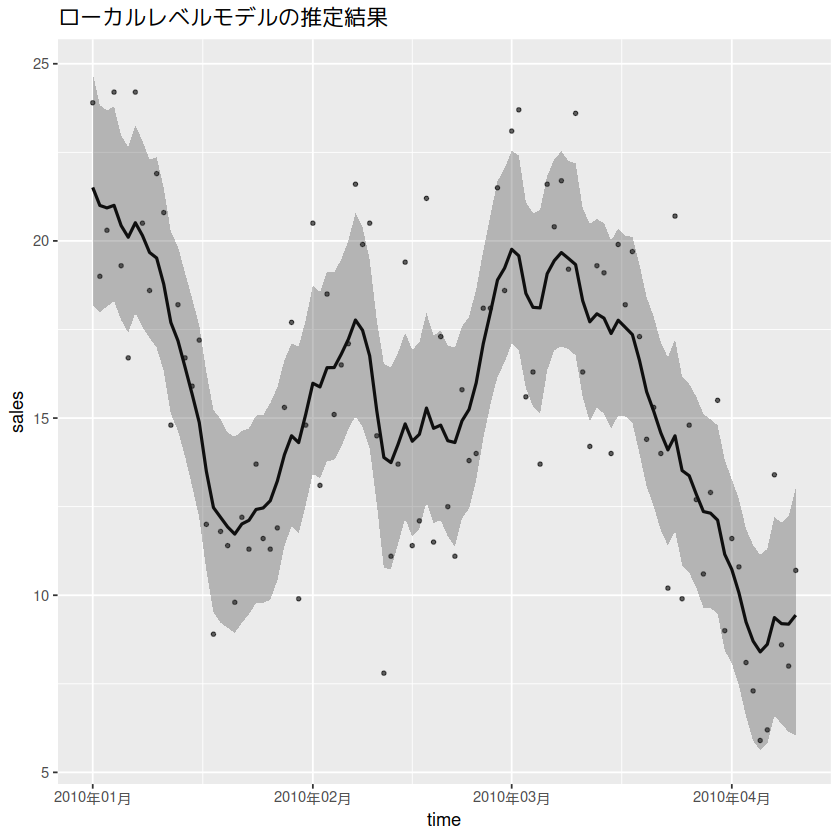

In [41]:
ggplot(data = result_df, aes(x = time, y = obs)) +
  labs(title = "ローカルレベルモデルの推定結果") +
  ylab("sales") +
  geom_point(alpha = 0.6, size = 0.9) +
  geom_line(aes(y = fit), size = 0.9) +
  geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3) +
  scale_x_datetime(date_labels = "%Y年%m月")
